In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

In [56]:
epochs = 100

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [57]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/m3gofriends/My-Machine-and-Deep-Learning-Template-main/main/Data/CSV/wcbreast_wdbc.csv",
    na_values=['NA', '?'])

In [58]:
df.head()

,id,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [59]:
# Convert to numpy - Classification
x_columns = df.columns.drop('diagnosis').drop('id')
for col in x_columns:
    df[col] = zscore(df[col])

x = df[x_columns].values
y = df['diagnosis'].map({'M':1,"B":0}).values # Binary classification, M is 1 and B is 0 

In [60]:
print(x.shape)
print(y.shape)

(569, 30)
(569,)


In [61]:
df.head()

,id,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,842517,M,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,84300903,M,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,84348301,M,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,84358402,M,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [62]:
# Split into train/test
x_train, y_train, x_test, y_test = train_test_split(x, y, test_size=0.2)

In [63]:
# Train
print(x_train.shape)
print(x_test.shape) # Label

# Test
print(y_train.shape)
print(y_test.shape) # Label

(455, 30)
(455,)
(114, 30)
(114,)


In [64]:
x_train = torch.Tensor(x_train).cuda()
x_test = torch.Tensor(x_test).cuda()
y_train = torch.Tensor(y_train).cuda()
y_test = torch.Tensor(y_test).cuda()

In [65]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(30, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

In [66]:
network = Net()
network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-2, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True, min_lr=1e-10)

In [67]:
train_losses = []
train_counter = []
test_accuracy = []
test_losses = []

In [68]:
def train(epoch):
  network.train()
  optimizer.zero_grad()
  pred = network(x_train)
  loss = F.binary_cross_entropy(pred.view(-1), x_test)
  loss.backward()
  optimizer.step()
  #scheduler.step(loss)

  print('Train Epoch : {}, Loss : {:.6f}'.format(epoch, loss.item()))
  train_losses.append(loss.item())
  train_counter.append(epoch)

In [69]:
def test(epoch):
  correct = 0
  network.eval()
  with torch.no_grad():
    pred = network(y_train)
    pred = torch.where(pred.view(-1) > 0.5, 1.0, 0.0) # If value > 0.5, value = 1.0, else value = 0.0
    correct = torch.eq(pred, y_test).sum().item()
    loss = F.binary_cross_entropy(pred.view(-1), y_test)
    scheduler.step(loss)

  print('Test Epoch : {}, Loss ; {:.6f}, Accuracy : [{}/{}] {:.1f}%'.format(epoch, loss.item(), correct , len(y_test), 100 * correct / len(y_test)))
  test_accuracy.append(100 * correct / len(y_test))
  test_losses.append(loss.item())

In [70]:
for epoch in range(1, epochs+1):
  train(epoch)
  test(epoch)

Train Epoch : 1, Loss : 0.690641
Test Epoch : 1, Loss ; 6.140351, Accuracy : [107/114] 93.9%
Train Epoch : 2, Loss : 0.356427
Test Epoch : 2, Loss ; 5.263158, Accuracy : [108/114] 94.7%
Train Epoch : 3, Loss : 0.192206
Test Epoch : 3, Loss ; 4.385965, Accuracy : [109/114] 95.6%
Train Epoch : 4, Loss : 0.133427
Test Epoch : 4, Loss ; 1.754386, Accuracy : [112/114] 98.2%
Train Epoch : 5, Loss : 0.094985
Test Epoch : 5, Loss ; 0.877193, Accuracy : [113/114] 99.1%
Train Epoch : 6, Loss : 0.082541
Test Epoch : 6, Loss ; 0.000000, Accuracy : [114/114] 100.0%
Train Epoch : 7, Loss : 0.092966
Test Epoch : 7, Loss ; 0.877193, Accuracy : [113/114] 99.1%
Train Epoch : 8, Loss : 0.112942
Test Epoch : 8, Loss ; 0.877193, Accuracy : [113/114] 99.1%
Train Epoch : 9, Loss : 0.085015
Test Epoch : 9, Loss ; 0.877193, Accuracy : [113/114] 99.1%
Train Epoch : 10, Loss : 0.064602
Test Epoch : 10, Loss ; 0.877193, Accuracy : [113/114] 99.1%
Train Epoch : 11, Loss : 0.060252
Test Epoch : 11, Loss ; 0.877193,

Text(0, 0.5, 'Loss')

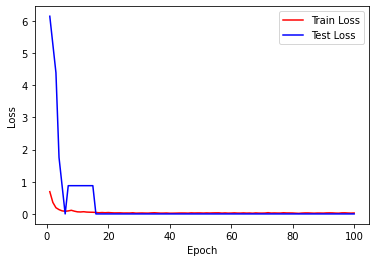

In [71]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_counter, train_losses, color='red')
plt.plot(train_counter, test_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

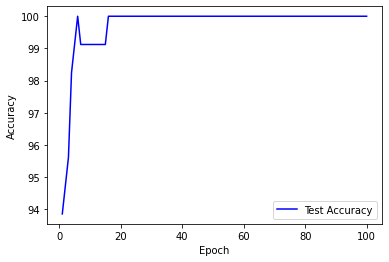

In [72]:
fig = plt.figure()
plt.plot(train_counter, test_accuracy, color='blue')
plt.legend(['Test Accuracy'], loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')